# Bike Sharing Demand

_url: https://www.kaggle.com/competitions/bike-sharing-demand/data_ </br>

✔️**Overview**
- Prdict bike rental demand in the Capital Bikeshare program in Washington, D.C, using <span style="color:blue">**historical usage patterns**</span> with <span style="color:blue">**weather data**</span> </br></br>

✔️**Evaluation**
- _RMSLE(Root Mean Squared Log Error)_
$$RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( \log (y_i + 1) - \log (\hat{y}_i + 1) \right)^2}$$
    여기서,  
    - \( n \) : 샘플 개수  
    - \( y_i \) : 실제값  
    - \( \hat{y}_i \) : 예측값  
    - \(\log (x + 1)\) : 로그 변환 (로그 함수에 0이 들어가는 것을 방지)
- RMSLE의 특징
    - 아웃라이어에 덜 민감
    - 상대적 Error를 측정: 값의 상대적 크기가 동일하다면 RMSLE의 값도 동일
    - Under Estimation에 큰 패널티 부여
</br></br>

✔️**Data Fields**</br>
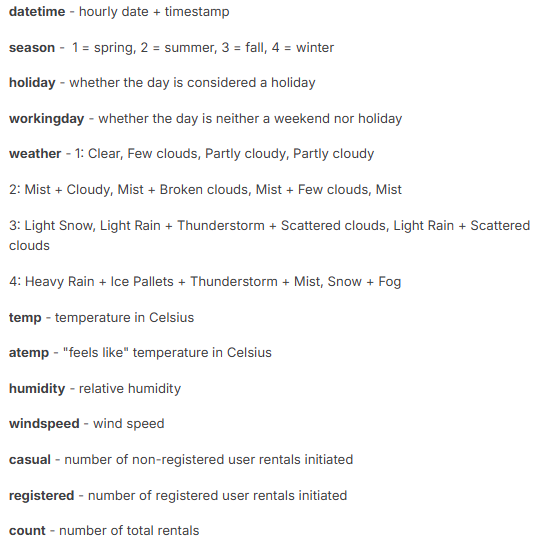

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import json
import sklearn
import re

#sklearn library
# 1.model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold

# 2.preprocessing
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler

mpl.rc('font',size=12)
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

## EDA

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [9]:
train.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [10]:
test.head()

datetime  season  holiday  workingday  weather   temp   atemp  \
0  2011-01-20 00:00:00       1        0           1        1  10.66  11.365   
1  2011-01-20 01:00:00       1        0           1        1  10.66  13.635   
2  2011-01-20 02:00:00       1        0           1        1  10.66  13.635   
3  2011-01-20 03:00:00       1        0           1        1  10.66  12.880   
4  2011-01-20 04:00:00       1        0           1        1  10.66  12.880   

   humidity  windspeed  
0        56    26.0027  
1        56     0.0000  
2        56     0.0000  
3        56    11.0014  
4        56    11.0014

✏️ **Data Insights**
- train데이터에는 **casual, registered** 피처가 있지만, <span style = "color:blue">test 데이터에는 **casual, registered** 피처가 없음</span>
- 모델 훈련시에 <span style = "color:red">**train 데이터의 casual, registered 피처 제거**</span>

In [11]:
train.shape, test.shape

((10886, 12), (6493, 9))

In [13]:
submission = pd.read_csv('./data/sampleSubmission.csv')
submission.head()

datetime  count
0  2011-01-20 00:00:00      0
1  2011-01-20 01:00:00      0
2  2011-01-20 02:00:00      0
3  2011-01-20 03:00:00      0
4  2011-01-20 04:00:00      0

✏️**Data Insights**
- datetime이 ID처럼 사용 → datetime은 예측에 도움을 주지 않음
- <span style = "color:red">**datetime 피처 제거**</span>

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [15]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


✏️ **train데이터**만 가공해서 분석

In [20]:
df = pd.read_csv('./data/train.csv')
df.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0       3          13     16  
1        80        0.0       8          32     40  
2        80        0.0       5          27     32  
3        75        0.0       3          10     13  
4        75        0.0       0           1      1

In [21]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [25]:
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday
df['weekday_name'] = df['datetime'].dt.day_name()
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['second'] = df['datetime'].dt.second

In [26]:
df.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0 2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1 2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2 2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3 2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4 2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  year  month  day  weekday  \
0        81        0.0       3          13     16  2011      1    1        5   
1        80        0.0       8          32     40  2011      1    1        5   
2        80        0.0       5          27     32  2011      1    1        5   
3        75        0.0       3          10     13  2011      1    1        5   
4        75        0.0       0           1      1  2011      1    1        5   

   hour  minute  second weekday_name  
0     0       0       0     Saturday  
1     1       0       0     Saturday  
2     2       0       0     Saturday  
3     3       0       0     Saturday  
4     4       0       0     Saturday

In [27]:
# 분석을 위해 season, weather 피처 문자형으로 변환
df['season'] = df['season'].replace({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})
df['weather'] = df['weather'].replace({1: 'Clear', 2: 'Mist, Cloudy', 3: 'Light Rain/Snow', 4: 'Heavy Rain/Snow'})

In [28]:
df.head()

datetime  season  holiday  workingday weather  temp   atemp  \
0 2011-01-01 00:00:00  Spring        0           0   Clear  9.84  14.395   
1 2011-01-01 01:00:00  Spring        0           0   Clear  9.02  13.635   
2 2011-01-01 02:00:00  Spring        0           0   Clear  9.02  13.635   
3 2011-01-01 03:00:00  Spring        0           0   Clear  9.84  14.395   
4 2011-01-01 04:00:00  Spring        0           0   Clear  9.84  14.395   

   humidity  windspeed  casual  registered  count  year  month  day  weekday  \
0        81        0.0       3          13     16  2011      1    1        5   
1        80        0.0       8          32     40  2011      1    1        5   
2        80        0.0       5          27     32  2011      1    1        5   
3        75        0.0       3          10     13  2011      1    1        5   
4        75        0.0       0           1      1  2011      1    1        5   

   hour  minute  second weekday_name  
0     0       0       0     Saturday  
1     1       0       0     Saturday  
2     2       0       0     Saturday  
3     3       0       0     Saturday  
4     4       0       0     Saturday

Text(0.5, 1.0, 'Target Distribution')

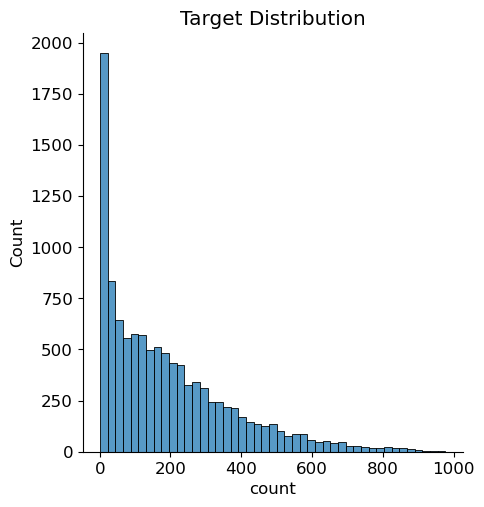

In [32]:
sns.displot(x='count', data=df)
plt.title("Target Distribution")

✏️**Data Insights**
- Target(count) 분포가 왼쪽으로 편향
- **로그변환**을 통해 분포를 정규분포에 가깝게 만들어서, 모델 성능을 향상시킴 
- 로그변환을 하게 되면, 마지막에 다시 **지수변환** 해줘야 함

Text(0.5, 1.0, 'Target Log Distribution')

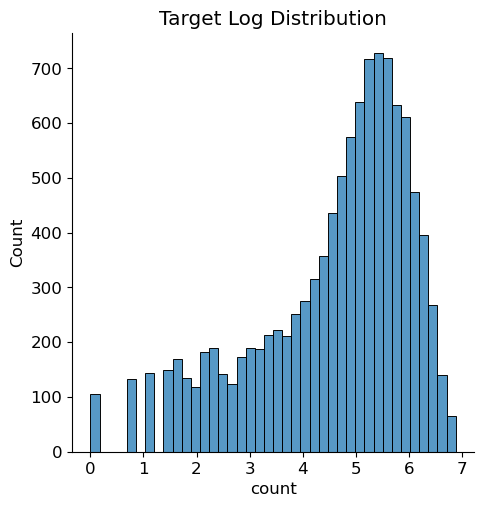

In [33]:
sns.displot(np.log(df['count']))
plt.title("Target Log Distribution")

<Axes: xlabel='year', ylabel='count'>

<Axes: xlabel='month', ylabel='count'>

<Axes: xlabel='day', ylabel='count'>

<Axes: xlabel='hour', ylabel='count'>

<Axes: xlabel='minute', ylabel='count'>

<Axes: xlabel='second', ylabel='count'>

<Axes: xlabel='weekday_name', ylabel='count'>

<Axes: xlabel='season', ylabel='count'>

<Axes: xlabel='weather', ylabel='count'>

<Axes: xlabel='holiday', ylabel='count'>

<Axes: xlabel='workingday', ylabel='count'>

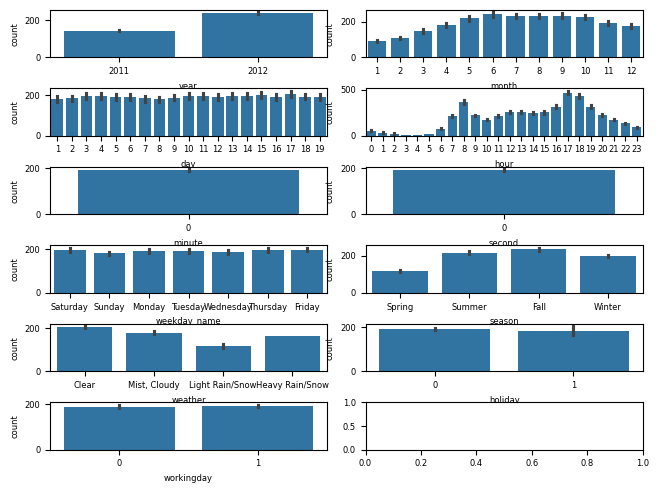

In [48]:
# datetime 시각화
mpl.rc('font',size=6)
figure, axes = plt.subplots(nrows = 6, ncols = 2)
plt.tight_layout()


sns.barplot(data = df, x='year', y='count', ax = axes[0,0])
sns.barplot(data = df, x='month', y='count', ax = axes[0,1])
sns.barplot(data = df, x='day', y='count', ax = axes[1,0])
sns.barplot(data = df, x='hour', y='count', ax = axes[1,1])
sns.barplot(data = df, x='minute', y='count', ax = axes[2,0])
sns.barplot(data = df, x='second', y='count', ax = axes[2,1])
sns.barplot(data = df, x='weekday_name', y='count', ax = axes[3,0])
sns.barplot(data = df, x='season', y='count', ax = axes[3,1])
sns.barplot(data = df, x='weather', y='count', ax = axes[4,0])
sns.barplot(data = df, x='holiday', y='count', ax = axes[4,1])
sns.barplot(data = df, x='workingday', y='count', ax = axes[5,0])

✏️**Data Insights**
- 추울 때는 자전거 대여량 감소, 여름,가을에 대여량이 많음
- 출퇴근 시간 대에 대여량이 많음
- Heavy Rain/Snow에 은근 자전거 대여량이 있다(?)

<Axes: >

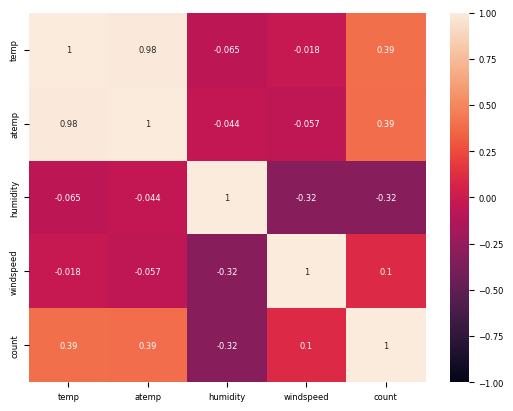

In [50]:
# 수치형 변수들과 Target의 상관계수
corr = df[['temp','atemp','humidity','windspeed','count']].corr()
sns.heatmap(corr, annot=True, vmax=1.0,vmin=-1.0)

✏️**Data Insights**
- 기온(temp), 체감온도(atemp)가 올라갈수록 대여량 많음
- 습도가 낮을수록 대여량 많음
- windspeed는 매우 약한 상관관계를 보임 

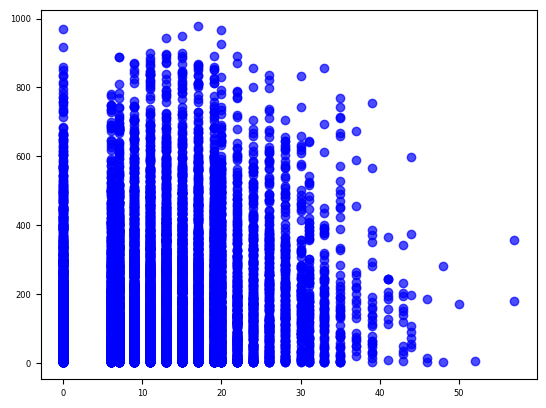

In [51]:
# windspeed와 count의 산점도
# 풍속이 0인 값이 많다 => 풍속이 0일수 있는가?
plt.scatter(df['windspeed'], df['count'], color='blue', alpha=0.7)

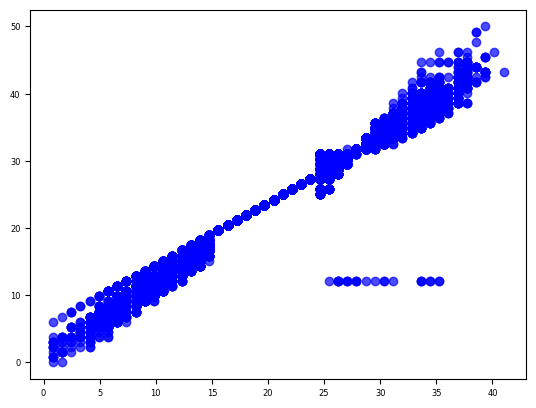

In [59]:
plt.scatter(df['temp'], df['atemp'], color='blue', alpha=0.7)

## Feature Engineering

In [52]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

In [54]:
df = pd.concat([train,test],ignore_index=True)
df.head()

datetime  season  holiday  workingday  weather  temp   atemp  \
0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
2  2011-01-01 02:00:00       1        0           0        1  9.02  13.635   
3  2011-01-01 03:00:00       1        0           0        1  9.84  14.395   
4  2011-01-01 04:00:00       1        0           0        1  9.84  14.395   

   humidity  windspeed  casual  registered  count  
0        81        0.0     3.0        13.0   16.0  
1        80        0.0     8.0        32.0   40.0  
2        80        0.0     5.0        27.0   32.0  
3        75        0.0     3.0        10.0   13.0  
4        75        0.0     0.0         1.0    1.0

In [55]:
df['datetime'] = pd.to_datetime(df['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    17379 non-null  datetime64[ns]
 1   season      17379 non-null  int64         
 2   holiday     17379 non-null  int64         
 3   workingday  17379 non-null  int64         
 4   weather     17379 non-null  int64         
 5   temp        17379 non-null  float64       
 6   atemp       17379 non-null  float64       
 7   humidity    17379 non-null  int64         
 8   windspeed   17379 non-null  float64       
 9   casual      10886 non-null  float64       
 10  registered  10886 non-null  float64       
 11  count       10886 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(5)
memory usage: 1.6 MB


In [56]:
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['weekday'] = df['datetime'].dt.weekday
df['hour'] = df['datetime'].dt.hour

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    17379 non-null  datetime64[ns]
 1   season      17379 non-null  int64         
 2   holiday     17379 non-null  int64         
 3   workingday  17379 non-null  int64         
 4   weather     17379 non-null  int64         
 5   temp        17379 non-null  float64       
 6   atemp       17379 non-null  float64       
 7   humidity    17379 non-null  int64         
 8   windspeed   17379 non-null  float64       
 9   casual      10886 non-null  float64       
 10  registered  10886 non-null  float64       
 11  count       10886 non-null  float64       
 12  year        17379 non-null  int32         
 13  month       17379 non-null  int32         
 14  day         17379 non-null  int32         
 15  weekday     17379 non-null  int32         
 16  hour        17379 non-

In [60]:
# 필요 없는 피처 제거
df.drop(['datetime','casual','registered','windspeed','month'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   holiday     17379 non-null  int64  
 2   workingday  17379 non-null  int64  
 3   weather     17379 non-null  int64  
 4   temp        17379 non-null  float64
 5   atemp       17379 non-null  float64
 6   humidity    17379 non-null  int64  
 7   count       10886 non-null  float64
 8   year        17379 non-null  int32  
 9   day         17379 non-null  int32  
 10  weekday     17379 non-null  int32  
 11  hour        17379 non-null  int32  
dtypes: float64(3), int32(4), int64(5)
memory usage: 1.3 MB


In [61]:
df.head()

season  holiday  workingday  weather  temp   atemp  humidity  count  year  \
0       1        0           0        1  9.84  14.395        81   16.0  2011   
1       1        0           0        1  9.02  13.635        80   40.0  2011   
2       1        0           0        1  9.02  13.635        80   32.0  2011   
3       1        0           0        1  9.84  14.395        75   13.0  2011   
4       1        0           0        1  9.84  14.395        75    1.0  2011   

   day  weekday  hour  
0    1        5     0  
1    1        5     1  
2    1        5     2  
3    1        5     3  
4    1        5     4

In [62]:
# 데이터 분리(train, test)
train = df[~pd.isnull(df['count'])]
test = df[pd.isnull(df['count'])]

In [64]:
train.shape

(10886, 12)

In [65]:
test.head()

season  holiday  workingday  weather   temp   atemp  humidity  count  \
10886       1        0           1        1  10.66  11.365        56    NaN   
10887       1        0           1        1  10.66  13.635        56    NaN   
10888       1        0           1        1  10.66  13.635        56    NaN   
10889       1        0           1        1  10.66  12.880        56    NaN   
10890       1        0           1        1  10.66  12.880        56    NaN   

       year  day  weekday  hour  
10886  2011   20        3     0  
10887  2011   20        3     1  
10888  2011   20        3     2  
10889  2011   20        3     3  
10890  2011   20        3     4

In [81]:
X_test = test.drop(columns = ['count'])

In [66]:
X = train.drop(columns = ['count'])
y = train['count'].values
X.head()
y

season  holiday  workingday  weather  temp   atemp  humidity  year  day  \
0       1        0           0        1  9.84  14.395        81  2011    1   
1       1        0           0        1  9.02  13.635        80  2011    1   
2       1        0           0        1  9.02  13.635        80  2011    1   
3       1        0           0        1  9.84  14.395        75  2011    1   
4       1        0           0        1  9.84  14.395        75  2011    1   

   weekday  hour  
0        5     0  
1        5     1  
2        5     2  
3        5     3  
4        5     4

array([ 16.,  40.,  32., ..., 168., 129.,  88.])

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1,random_state=42)

## Modeling

In [69]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# 모델 리스트
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'K-Nearest Neighbors': KNeighborsRegressor(),
    'Support Vector Regressor': SVR(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42),
    'LightGBM': LGBMRegressor(random_state=42),
}

In [70]:
# 평가지표 (RMSLE)
def rmsle(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # 로그 변환 (log1p = log(x + 1)과 동일)
    log_true = np.log1p(y_true)
    log_pred = np.log1p(y_pred)
    
    # 로그 차이의 제곱 평균 후 제곱근
    rmsle_value = np.sqrt(np.mean((log_true - log_pred) ** 2))
    
    return rmsle_value

In [73]:
# 모델 학습 및 평가
results = {}
for model_name, model in models.items():
    log_y = np.log(y_train)
    model.fit(X_train, log_y)
    preds = model.predict(X_valid)
    exp_preds = np.exp(preds)
    result_rmsle = rmsle(y_valid, exp_preds)
    results[model_name] = result_rmsle
    print(f"{model_name} RMSLE : {result_rmsle:.4f}")

LinearRegression()

Linear Regression RMSLE : 1.0285


Ridge()

Ridge Regression RMSLE : 1.0285


Lasso(alpha=0.1)

Lasso Regression RMSLE : 1.0528


KNeighborsRegressor()

K-Nearest Neighbors RMSLE : 0.7140


SVR()

Support Vector Regressor RMSLE : 1.3268


DecisionTreeRegressor(random_state=42)

Decision Tree RMSLE : 0.4030


RandomForestRegressor(random_state=42)

Random Forest RMSLE : 0.2846


GradientBoostingRegressor(random_state=42)

Gradient Boosting RMSLE : 0.3879


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

XGBoost RMSLE : 0.2791
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205


LGBMRegressor(random_state=42)

LightGBM RMSLE : 0.2792


In [77]:
import optuna
from lightgbm import LGBMRegressor


# Optuna objective 함수 정의
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'num_leaves': trial.suggest_int('num_leaves', 20, 200),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1)
    }
    
    model = LGBMRegressor(**params)
    
    # 모델 훈련 후 예측
    log_y = np.log(y_train)
    model.fit(X_train, log_y)
    preds = model.predict(X_valid)
    exp_preds = np.exp(preds)
    result_rmsle = rmsle(y_valid, exp_preds)
    
    return result_rmsle

# Optuna Study 생성
study = optuna.create_study(direction="minimize")  # RMSLE는 최소화해야 하므로 'minimize' 설정
study.optimize(objective, n_trials=100)

# 최적 하이퍼파라미터 출력
print("Best parameters:", study.best_params)
print("Best RMSLE:", study.best_value)

# Train the best model
best_params = study.best_params
best_model = LGBMRegressor(**best_params, random_state=42)
log_y = np.log(y_train)
best_model.fit(X_train, log_y)

# Valid Set 성능 확인
val_preds = best_model.predict(X_valid)
exp_val_preds = np.exp(val_preds)
result_rmlse = rmsle(y_valid, exp_val_preds)
print("Final validation accuracy with best model: ", result_rmlse)

[I 2025-02-02 02:54:01,075] A new study created in memory with name: no-name-381bf2a3-b65c-4652-b2ed-437dc3bc455f


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:54:02,848] Trial 0 finished with value: 0.26480671342979833 and parameters: {'n_estimators': 962, 'learning_rate': 0.08008524009019179, 'max_depth': 7, 'num_leaves': 60, 'min_child_samples': 25, 'subsample': 0.6588608925331889, 'colsample_bytree': 0.9954648127834651, 'reg_alpha': 0.8291620198401005, 'reg_lambda': 0.08184542234066561}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:54:03,549] Trial 1 finished with value: 0.27477869840100283 and parameters: {'n_estimators': 302, 'learning_rate': 0.14548326509105286, 'max_depth': 10, 'num_leaves': 88, 'min_child_samples': 22, 'subsample': 0.7206493190501753, 'colsample_bytree': 0.6782252005451279, 'reg_alpha': 0.5117867497797285, 'reg_lambda': 0.8268203104014359}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, nu

[I 2025-02-02 02:54:08,574] Trial 2 finished with value: 0.26877239615860027 and parameters: {'n_estimators': 923, 'learning_rate': 0.013770726743792504, 'max_depth': 9, 'num_leaves': 144, 'min_child_samples': 10, 'subsample': 0.5991020647299282, 'colsample_bytree': 0.775421784603045, 'reg_alpha': 0.8431721459253029, 'reg_lambda': 0.334087086209384}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:54:09,234] Trial 3 finished with value: 0.26858768755063167 and parameters: {'n_estimators': 200, 'learning_rate': 0.14712499078419689, 'max_depth': 8, 'num_leaves': 156, 'min_child_samples': 24, 'subsample': 0.7859970394004214, 'colsample_bytree': 0.939150055427881, 'reg_alpha': 0.4540892616624157, 'reg_lambda': 0.8586945526194154}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:54:10,354] Trial 4 finished with value: 0.2728806326832445 and parameters: {'n_estimators': 848, 'learning_rate': 0.11598684238621168, 'max_depth': 11, 'num_leaves': 69, 'min_child_samples': 38, 'subsample': 0.5819289277935381, 'colsample_bytree': 0.5531033044150673, 'reg_alpha': 0.9885658908580365, 'reg_lambda': 0.7296238988416224}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-02 02:54:11,022] Trial 5 finished with value: 0.27773959651409724 and parameters: {'n_estimators': 236, 'learning_rate': 0.18768596010474642, 'max_depth': 11, 'num_leaves': 89, 'min_child_samples': 14, 'subsample': 0.6630467909253787, 'colsample_bytree': 0.6186600485350557, 'reg_alpha': 0.17206812940542648, 'reg_lambda': 0.8978995803725154}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:54:11,250] Trial 6 finished with value: 0.276755861837177 and parameters: {'n_estimators': 179, 'learning_rate': 0.14137300910017603, 'max_depth': 8, 'num_leaves': 179, 'min_child_samples': 93, 'subsample': 0.9829751265916464, 'colsample_bytree': 0.9491342494673134, 'reg_alpha': 0.6000436357239188, 'reg_lambda': 0.7980609116649273}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:54:12,383] Trial 7 finished with value: 0.2714932603754148 and parameters: {'n_estimators': 403, 'learning_rate': 0.09239243190077083, 'max_depth': 12, 'num_leaves': 157, 'min_child_samples': 79, 'subsample': 0.9110446993598538, 'colsample_bytree': 0.9722184623422347, 'reg_alpha': 0.05681583224321507, 'reg_lambda': 0.8824913488029081}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:54:14,250] Trial 8 finished with value: 0.27219075736993076 and parameters: {'n_estimators': 397, 'learning_rate': 0.08705903329259222, 'max_depth': 8, 'num_leaves': 116, 'min_child_samples': 7, 'subsample': 0.5428124935375561, 'colsample_bytree': 0.6248720817082496, 'reg_alpha': 0.9879103285144236, 'reg_lambda': 0.5645366029644018}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:54:17,389] Trial 9 finished with value: 0.26980269374157123 and parameters: {'n_estimators': 815, 'learning_rate': 0.053577546377129796, 'max_depth': 9, 'num_leaves': 133, 'min_child_samples': 21, 'subsample': 0.7406269639004093, 'colsample_bytree': 0.6539759473351445, 'reg_alpha': 0.9361296275724734, 'reg_lambda': 0.9325138685359884}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:54:17,940] Trial 10 finished with value: 0.29682116532636876 and parameters: {'n_estimators': 642, 'learning_rate': 0.04918421699252513, 'max_depth': 3, 'num_leaves': 28, 'min_child_samples': 57, 'subsample': 0.8417701543831555, 'colsample_bytree': 0.8237011364141125, 'reg_alpha': 0.7177986125074859, 'reg_lambda': 0.04367064139164462}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-02 02:54:18,978] Trial 11 finished with value: 0.27318206974593856 and parameters: {'n_estimators': 629, 'learning_rate': 0.18585731437075803, 'max_depth': 20, 'num_leaves': 35, 'min_child_samples': 44, 'subsample': 0.8286257903639129, 'colsample_bytree': 0.8820456670971273, 'reg_alpha': 0.2941440492648017, 'reg_lambda': 0.02276898108182391}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:54:19,418] Trial 12 finished with value: 0.2945170469032864 and parameters: {'n_estimators': 130, 'learning_rate': 0.1450415094530837, 'max_depth': 4, 'num_leaves': 189, 'min_child_samples': 39, 'subsample': 0.6681106946427423, 'colsample_bytree': 0.9900188102816048, 'reg_alpha': 0.3474394545282715, 'reg_lambda': 0.2992809301069673}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-02 02:54:22,431] Trial 13 finished with value: 0.2705682706055917 and parameters: {'n_estimators': 994, 'learning_rate': 0.11652626948374462, 'max_depth': 15, 'num_leaves': 68, 'min_child_samples': 59, 'subsample': 0.8013054875104553, 'colsample_bytree': 0.8591347817027398, 'reg_alpha': 0.6956439998541741, 'reg_lambda': 0.5980631515003232}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:54:23,387] Trial 14 finished with value: 0.270217830104918 and parameters: {'n_estimators': 567, 'learning_rate': 0.0663125877627197, 'max_depth': 6, 'num_leaves': 167, 'min_child_samples': 26, 'subsample': 0.6705710477357427, 'colsample_bytree': 0.9112389037561911, 'reg_alpha': 0.40907931399267106, 'reg_lambda': 0.2530910941191958}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

[I 2025-02-02 02:54:24,599] Trial 15 finished with value: 0.28843007441867546 and parameters: {'n_estimators': 778, 'learning_rate': 0.010280134591327067, 'max_depth': 6, 'num_leaves': 200, 'min_child_samples': 28, 'subsample': 0.5086112155109637, 'colsample_bytree': 0.7378025701001955, 'reg_alpha': 0.5319020209051336, 'reg_lambda': 0.4528546142083308}. Best is trial 0 with value: 0.26480671342979833.
[I 2025-02-02 02:54:24,724] Trial 16 finished with value: 0.2915320152934671 and parameters: {'n_estimators': 50, 'learning_rate': 0.15532223671206147, 'max_depth': 14, 'num_leaves': 55, 'min_child_samples': 49, 'subsample': 0.7963753991462287, 'colsample_bytree': 0.921521112768388, 'reg_alpha': 0.7773535951249512, 'reg_lambda': 0.16201454230904178}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

[I 2025-02-02 02:54:25,298] Trial 17 finished with value: 0.2699513165889262 and parameters: {'n_estimators': 451, 'learning_rate': 0.11806491518750244, 'max_depth': 6, 'num_leaves': 110, 'min_child_samples': 69, 'subsample': 0.9242469417140409, 'colsample_bytree': 0.8070406554105589, 'reg_alpha': 0.6365576057408417, 'reg_lambda': 0.6859200968645345}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-02 02:54:27,046] Trial 18 finished with value: 0.27857969345378153 and parameters: {'n_estimators': 705, 'learning_rate': 0.1652522511647877, 'max_depth': 14, 'num_leaves': 114, 'min_child_samples': 34, 'subsample': 0.6292248541050705, 'colsample_bytree': 0.995972032196591, 'reg_alpha': 0.42154398485114936, 'reg_lambda': 0.47808449117993995}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205


[I 2025-02-02 02:54:27,878] Trial 19 finished with value: 0.27413223634410017 and parameters: {'n_estimators': 310, 'learning_rate': 0.032557165521008166, 'max_depth': 17, 'num_leaves': 47, 'min_child_samples': 17, 'subsample': 0.7206815754730017, 'colsample_bytree': 0.8634277750394738, 'reg_alpha': 0.19883378930451756, 'reg_lambda': 0.15450549614694495}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:54:28,417] Trial 20 finished with value: 0.28495283473838107 and parameters: {'n_estimators': 504, 'learning_rate': 0.078901392128885, 'max_depth': 4, 'num_leaves': 86, 'min_child_samples': 33, 'subsample': 0.8742014499760158, 'colsample_bytree': 0.7237560644254774, 'reg_alpha': 0.8603324800673143, 'reg_lambda': 0.39920277848751545}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-02 02:54:30,787] Trial 21 finished with value: 0.26618788766907686 and parameters: {'n_estimators': 998, 'learning_rate': 0.022175595759958956, 'max_depth': 7, 'num_leaves': 145, 'min_child_samples': 5, 'subsample': 0.6048776940043803, 'colsample_bytree': 0.7981761613712495, 'reg_alpha': 0.8401768650742554, 'reg_lambda': 0.34374858822090415}. Best is trial 0 with value: 0.26480671342979833.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:54:33,065] Trial 22 finished with value: 0.26297213277512865 and parameters: {'n_estimators': 958, 'learning_rate': 0.028980404865233136, 'max_depth': 7, 'num_leaves': 138, 'min_child_samples': 5, 'subsample': 0.7646812268646332, 'colsample_bytree': 0.9413467105537593, 'reg_alpha': 0.8369331180590532, 'reg_lambda': 0.1770330251760243}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:54:34,638] Trial 23 finished with value: 0.27191997516913086 and parameters: {'n_estimators': 982, 'learning_rate': 0.02527434492268414, 'max_depth': 5, 'num_leaves': 133, 'min_child_samples': 6, 'subsample': 0.6204190398862486, 'colsample_bytree': 0.8985641654153222, 'reg_alpha': 0.8418371402289503, 'reg_lambda': 0.1726514876035191}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:54:37,105] Trial 24 finished with value: 0.265574984278131 and parameters: {'n_estimators': 906, 'learning_rate': 0.03782273986046779, 'max_depth': 7, 'num_leaves': 132, 'min_child_samples': 5, 'subsample': 0.5661245218844886, 'colsample_bytree': 0.8362058913585233, 'reg_alpha': 0.752609714430226, 'reg_lambda': 0.09063348560321455}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:54:37,962] Trial 25 finished with value: 0.2982474843860844 and parameters: {'n_estimators': 890, 'learning_rate': 0.04177819199908233, 'max_depth': 3, 'num_leaves': 99, 'min_child_samples': 15, 'subsample': 0.5511207323593164, 'colsample_bytree': 0.9534724573388013, 'reg_alpha': 0.7562284296725773, 'reg_lambda': 0.08909765068952495}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-02 02:54:39,746] Trial 26 finished with value: 0.6986394668625303 and parameters: {'n_estimators': 736, 'learning_rate': 0.0014398645134924004, 'max_depth': 7, 'num_leaves': 135, 'min_child_samples': 14, 'subsample': 0.7016199215895015, 'colsample_bytree': 0.8407689974582245, 'reg_alpha': 0.6429643094378645, 'reg_lambda': 0.23153049773480522}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:54:41,253] Trial 27 finished with value: 0.26499756252778767 and parameters: {'n_estimators': 909, 'learning_rate': 0.06378972932666008, 'max_depth': 12, 'num_leaves': 121, 'min_child_samples': 13, 'subsample': 0.7652645242891287, 'colsample_bytree': 0.8954921602788745, 'reg_alpha': 0.9188928644918889, 'reg_lambda': 0.008597865455833673}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:54:42,835] Trial 28 finished with value: 0.2650948623525679 and parameters: {'n_estimators': 848, 'learning_rate': 0.06528965555912267, 'max_depth': 13, 'num_leaves': 71, 'min_child_samples': 30, 'subsample': 0.7728366837545548, 'colsample_bytree': 0.9986915128119606, 'reg_alpha': 0.9048491073875808, 'reg_lambda': 0.02362322566274319}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:54:45,603] Trial 29 finished with value: 0.26560067967174783 and parameters: {'n_estimators': 931, 'learning_rate': 0.06578079590183207, 'max_depth': 10, 'num_leaves': 102, 'min_child_samples': 17, 'subsample': 0.7577642137554403, 'colsample_bytree': 0.9237609712495923, 'reg_alpha': 0.555546618496367, 'reg_lambda': 0.11200486368712227}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:54:47,353] Trial 30 finished with value: 0.2686387561807576 and parameters: {'n_estimators': 726, 'learning_rate': 0.09949587121783796, 'max_depth': 16, 'num_leaves': 117, 'min_child_samples': 23, 'subsample': 0.6987510878745233, 'colsample_bytree': 0.8961936466396805, 'reg_alpha': 0.9032423091577043, 'reg_lambda': 0.20332267241639174}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:54:49,401] Trial 31 finished with value: 0.26737541434800344 and parameters: {'n_estimators': 851, 'learning_rate': 0.06485284759206075, 'max_depth': 13, 'num_leaves': 75, 'min_child_samples': 31, 'subsample': 0.7604107951968063, 'colsample_bytree': 0.9612625958071624, 'reg_alpha': 0.928270100646952, 'reg_lambda': 0.01334707557166133}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205


[I 2025-02-02 02:54:51,575] Trial 32 finished with value: 0.26709937726933625 and parameters: {'n_estimators': 932, 'learning_rate': 0.07156358341456245, 'max_depth': 12, 'num_leaves': 55, 'min_child_samples': 12, 'subsample': 0.8325352719924977, 'colsample_bytree': 0.9863917432760985, 'reg_alpha': 0.807257033698154, 'reg_lambda': 0.07783026157659624}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:54:53,602] Trial 33 finished with value: 0.2648123088262461 and parameters: {'n_estimators': 798, 'learning_rate': 0.05730307887686852, 'max_depth': 10, 'num_leaves': 82, 'min_child_samples': 21, 'subsample': 0.7691468973488599, 'colsample_bytree': 0.9415053129388588, 'reg_alpha': 0.9019355071160813, 'reg_lambda': 0.0044973578259320905}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:54:55,778] Trial 34 finished with value: 0.264230176799615 and parameters: {'n_estimators': 799, 'learning_rate': 0.05253387496084848, 'max_depth': 10, 'num_leaves': 90, 'min_child_samples': 21, 'subsample': 0.7279828280237955, 'colsample_bytree': 0.942600466043534, 'reg_alpha': 0.991697026252248, 'reg_lambda': 0.001877599879378855}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:54:57,533] Trial 35 finished with value: 0.2737338572756466 and parameters: {'n_estimators': 788, 'learning_rate': 0.05141271383287595, 'max_depth': 10, 'num_leaves': 88, 'min_child_samples': 20, 'subsample': 0.724676734104612, 'colsample_bytree': 0.5328592381739734, 'reg_alpha': 0.9833335340305287, 'reg_lambda': 0.13870283173682368}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:54:59,429] Trial 36 finished with value: 0.26932521559774025 and parameters: {'n_estimators': 659, 'learning_rate': 0.08208983463771558, 'max_depth': 9, 'num_leaves': 78, 'min_child_samples': 40, 'subsample': 0.6438808052023463, 'colsample_bytree': 0.9408271086356547, 'reg_alpha': 0.6897644569281721, 'reg_lambda': 0.9949025320580042}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-02 02:55:01,075] Trial 37 finished with value: 0.265509686072502 and parameters: {'n_estimators': 821, 'learning_rate': 0.020371711518073897, 'max_depth': 9, 'num_leaves': 59, 'min_child_samples': 22, 'subsample': 0.6905032456300841, 'colsample_bytree': 0.7776694541238238, 'reg_alpha': 0.8615476755328829, 'reg_lambda': 0.2823348237257103}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:02,625] Trial 38 finished with value: 0.2681586803067356 and parameters: {'n_estimators': 951, 'learning_rate': 0.10573713912606056, 'max_depth': 11, 'num_leaves': 97, 'min_child_samples': 10, 'subsample': 0.8042372577837259, 'colsample_bytree': 0.9648385110291569, 'reg_alpha': 0.995877289394199, 'reg_lambda': 0.20311196308943702}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000362 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:03,712] Trial 39 finished with value: 0.2717239208705253 and parameters: {'n_estimators': 772, 'learning_rate': 0.0473124378324566, 'max_depth': 8, 'num_leaves': 47, 'min_child_samples': 98, 'subsample': 0.734040139394984, 'colsample_bytree': 0.9386576091360463, 'reg_alpha': 0.7911499075767165, 'reg_lambda': 0.07696412713013609}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205


[I 2025-02-02 02:55:04,839] Trial 40 finished with value: 0.2759750159248864 and parameters: {'n_estimators': 879, 'learning_rate': 0.03107287410802018, 'max_depth': 10, 'num_leaves': 20, 'min_child_samples': 81, 'subsample': 0.8732588606755679, 'colsample_bytree': 0.7014292899011869, 'reg_alpha': 0.8858961857222317, 'reg_lambda': 0.11536717035397695}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000826 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:55:06,786] Trial 41 finished with value: 0.2700982275189742 and parameters: {'n_estimators': 936, 'learning_rate': 0.07639485850685837, 'max_depth': 11, 'num_leaves': 125, 'min_child_samples': 10, 'subsample': 0.7479655383858286, 'colsample_bytree': 0.8797190541639465, 'reg_alpha': 0.9341181807208258, 'reg_lambda': 0.054061104651357564}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:08,979] Trial 42 finished with value: 0.26490870022125357 and parameters: {'n_estimators': 871, 'learning_rate': 0.056306324223732745, 'max_depth': 9, 'num_leaves': 145, 'min_child_samples': 19, 'subsample': 0.7779090309319616, 'colsample_bytree': 0.9256631939442623, 'reg_alpha': 0.9597078502015516, 'reg_lambda': 0.005449146726901633}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:10,952] Trial 43 finished with value: 0.26734149911330646 and parameters: {'n_estimators': 847, 'learning_rate': 0.05427754856340877, 'max_depth': 8, 'num_leaves': 154, 'min_child_samples': 25, 'subsample': 0.785427033310673, 'colsample_bytree': 0.9693223307586099, 'reg_alpha': 0.9516417322584908, 'reg_lambda': 0.01075732633658711}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:12,594] Trial 44 finished with value: 0.2668737489437406 and parameters: {'n_estimators': 585, 'learning_rate': 0.0940826067468871, 'max_depth': 9, 'num_leaves': 164, 'min_child_samples': 18, 'subsample': 0.6870927920516169, 'colsample_bytree': 0.9232867835111839, 'reg_alpha': 0.9689168416843361, 'reg_lambda': 0.0630615167434462}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:14,191] Trial 45 finished with value: 0.2638689595960362 and parameters: {'n_estimators': 692, 'learning_rate': 0.056555077632876365, 'max_depth': 7, 'num_leaves': 149, 'min_child_samples': 44, 'subsample': 0.8188341224621458, 'colsample_bytree': 0.9349005136637212, 'reg_alpha': 0.8090700252240675, 'reg_lambda': 0.0011701745916810333}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:55:14,820] Trial 46 finished with value: 0.2753445278579016 and parameters: {'n_estimators': 691, 'learning_rate': 0.03954192921322784, 'max_depth': 5, 'num_leaves': 175, 'min_child_samples': 50, 'subsample': 0.8194039930032654, 'colsample_bytree': 0.8678067927477222, 'reg_alpha': 0.8037005298242051, 'reg_lambda': 0.11441230817105691}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:55:16,288] Trial 47 finished with value: 0.2673210865783315 and parameters: {'n_estimators': 757, 'learning_rate': 0.08867392407191996, 'max_depth': 7, 'num_leaves': 65, 'min_child_samples': 46, 'subsample': 0.856750347763885, 'colsample_bytree': 0.5991870056138691, 'reg_alpha': 0.7168169368151274, 'reg_lambda': 0.19930278341312127}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:55:17,787] Trial 48 finished with value: 0.30172886577652197 and parameters: {'n_estimators': 804, 'learning_rate': 0.007747363108697669, 'max_depth': 6, 'num_leaves': 81, 'min_child_samples': 59, 'subsample': 0.9209373445428277, 'colsample_bytree': 0.9458351428640277, 'reg_alpha': 0.8245348292921321, 'reg_lambda': 0.35103459966805783}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:18,324] Trial 49 finished with value: 0.2664261278425282 and parameters: {'n_estimators': 602, 'learning_rate': 0.13205745954745934, 'max_depth': 5, 'num_leaves': 106, 'min_child_samples': 36, 'subsample': 0.6521925109752641, 'colsample_bytree': 0.9783746657497905, 'reg_alpha': 0.6484860461187515, 'reg_lambda': 0.04951784989378914}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:55:19,854] Trial 50 finished with value: 0.26635609701254437 and parameters: {'n_estimators': 657, 'learning_rate': 0.05654909564096754, 'max_depth': 8, 'num_leaves': 95, 'min_child_samples': 41, 'subsample': 0.7079089867219911, 'colsample_bytree': 0.974657788189382, 'reg_alpha': 0.05662412942348016, 'reg_lambda': 0.15051665154492236}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:22,501] Trial 51 finished with value: 0.26779983342729224 and parameters: {'n_estimators': 875, 'learning_rate': 0.046990207037894666, 'max_depth': 10, 'num_leaves': 145, 'min_child_samples': 27, 'subsample': 0.78505892492843, 'colsample_bytree': 0.9294750926071494, 'reg_alpha': 0.8747888648254946, 'reg_lambda': 0.03793843393449113}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:24,776] Trial 52 finished with value: 0.26611096760906927 and parameters: {'n_estimators': 964, 'learning_rate': 0.05798870046465124, 'max_depth': 9, 'num_leaves': 152, 'min_child_samples': 23, 'subsample': 0.8209450863684679, 'colsample_bytree': 0.9094543625261224, 'reg_alpha': 0.9654179665743478, 'reg_lambda': 0.002698694117203443}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000160 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:26,322] Trial 53 finished with value: 0.2641191039355501 and parameters: {'n_estimators': 837, 'learning_rate': 0.07341327214415011, 'max_depth': 8, 'num_leaves': 165, 'min_child_samples': 19, 'subsample': 0.736830781778262, 'colsample_bytree': 0.9533321208854622, 'reg_alpha': 0.8943138037434656, 'reg_lambda': 0.00010059200110794126}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000372 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:28,088] Trial 54 finished with value: 0.27132873159195897 and parameters: {'n_estimators': 806, 'learning_rate': 0.07365960671343458, 'max_depth': 8, 'num_leaves': 164, 'min_child_samples': 67, 'subsample': 0.7424299919067454, 'colsample_bytree': 0.9590818386925147, 'reg_alpha': 0.7628599196754267, 'reg_lambda': 0.12165313887639351}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:28,770] Trial 55 finished with value: 0.26700620140066933 and parameters: {'n_estimators': 527, 'learning_rate': 0.0854867781120138, 'max_depth': 7, 'num_leaves': 181, 'min_child_samples': 54, 'subsample': 0.7151701185925246, 'colsample_bytree': 0.9958110101561569, 'reg_alpha': 0.8896769311008255, 'reg_lambda': 0.5338733521896725}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-02 02:55:29,525] Trial 56 finished with value: 0.26559424936040715 and parameters: {'n_estimators': 693, 'learning_rate': 0.032332604455081605, 'max_depth': 20, 'num_leaves': 44, 'min_child_samples': 9, 'subsample': 0.6685831252058122, 'colsample_bytree': 0.8824157233678875, 'reg_alpha': 0.486354916643341, 'reg_lambda': 0.6641436203797886}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:30,338] Trial 57 finished with value: 0.2680533436913776 and parameters: {'n_estimators': 831, 'learning_rate': 0.10808437462329469, 'max_depth': 6, 'num_leaves': 175, 'min_child_samples': 29, 'subsample': 0.8088662618383706, 'colsample_bytree': 0.9470066815016789, 'reg_alpha': 0.8416576770309421, 'reg_lambda': 0.05611768766363594}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:55:30,859] Trial 58 finished with value: 0.28409040013554204 and parameters: {'n_estimators': 959, 'learning_rate': 0.04349683194669979, 'max_depth': 4, 'num_leaves': 189, 'min_child_samples': 37, 'subsample': 0.8497134092844494, 'colsample_bytree': 0.9072851803213696, 'reg_alpha': 2.340697552560833e-05, 'reg_lambda': 0.24326030784376185}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:55:31,747] Trial 59 finished with value: 0.267989991056902 and parameters: {'n_estimators': 736, 'learning_rate': 0.0706573108580385, 'max_depth': 7, 'num_leaves': 158, 'min_child_samples': 33, 'subsample': 0.8946209108991575, 'colsample_bytree': 0.8488066576782135, 'reg_alpha': 0.5943767297846134, 'reg_lambda': 0.8010635648651382}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:55:34,821] Trial 60 finished with value: 0.2702273350234249 and parameters: {'n_estimators': 1000, 'learning_rate': 0.018621308711502305, 'max_depth': 11, 'num_leaves': 137, 'min_child_samples': 44, 'subsample': 0.6825715492708674, 'colsample_bytree': 0.8218545922590499, 'reg_alpha': 0.7199205854270904, 'reg_lambda': 0.09367379569600953}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:36,845] Trial 61 finished with value: 0.26509414762933686 and parameters: {'n_estimators': 876, 'learning_rate': 0.05704291065726333, 'max_depth': 9, 'num_leaves': 142, 'min_child_samples': 19, 'subsample': 0.7770520451121022, 'colsample_bytree': 0.9205546215349644, 'reg_alpha': 0.9453302567554482, 'reg_lambda': 0.03763595092005245}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:55:37,878] Trial 62 finished with value: 0.2704728267052263 and parameters: {'n_estimators': 898, 'learning_rate': 0.1975490004698219, 'max_depth': 8, 'num_leaves': 123, 'min_child_samples': 15, 'subsample': 0.953145125321728, 'colsample_bytree': 0.9826959931149832, 'reg_alpha': 0.9959158269241436, 'reg_lambda': 0.009431343280410218}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:39,629] Trial 63 finished with value: 0.2662160066113775 and parameters: {'n_estimators': 757, 'learning_rate': 0.07979448926318246, 'max_depth': 9, 'num_leaves': 152, 'min_child_samples': 25, 'subsample': 0.7386504813936688, 'colsample_bytree': 0.9354554370162761, 'reg_alpha': 0.9130923762856495, 'reg_lambda': 0.0008663681973852732}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000169 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:41,825] Trial 64 finished with value: 0.2645512445790866 and parameters: {'n_estimators': 862, 'learning_rate': 0.060680357839002996, 'max_depth': 10, 'num_leaves': 91, 'min_child_samples': 20, 'subsample': 0.7969956465004746, 'colsample_bytree': 0.954619559185309, 'reg_alpha': 0.8634517335882786, 'reg_lambda': 0.18073031263611072}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205


[I 2025-02-02 02:55:44,608] Trial 65 finished with value: 0.26361751572553355 and parameters: {'n_estimators': 911, 'learning_rate': 0.02783510022267475, 'max_depth': 11, 'num_leaves': 93, 'min_child_samples': 8, 'subsample': 0.8001211231497048, 'colsample_bytree': 0.9560067020222417, 'reg_alpha': 0.8634657018075541, 'reg_lambda': 0.18082877001613534}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000223 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205


[I 2025-02-02 02:55:47,723] Trial 66 finished with value: 0.2670112696751674 and parameters: {'n_estimators': 966, 'learning_rate': 0.014164070827765135, 'max_depth': 13, 'num_leaves': 92, 'min_child_samples': 8, 'subsample': 0.7940718472752618, 'colsample_bytree': 0.9636214077267037, 'reg_alpha': 0.8245169081688801, 'reg_lambda': 0.2822658671561181}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:50,859] Trial 67 finished with value: 0.2662924140876684 and parameters: {'n_estimators': 915, 'learning_rate': 0.037139656036266414, 'max_depth': 12, 'num_leaves': 109, 'min_child_samples': 13, 'subsample': 0.8388804783199799, 'colsample_bytree': 0.9793606030759596, 'reg_alpha': 0.7398406123396021, 'reg_lambda': 0.15635564049009462}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:52,804] Trial 68 finished with value: 0.2644325936856309 and parameters: {'n_estimators': 846, 'learning_rate': 0.027514636818596394, 'max_depth': 6, 'num_leaves': 103, 'min_child_samples': 6, 'subsample': 0.6004579710457406, 'colsample_bytree': 0.8846445825983051, 'reg_alpha': 0.7915530148380442, 'reg_lambda': 0.39534817728436733}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:54,266] Trial 69 finished with value: 0.2644410328668615 and parameters: {'n_estimators': 844, 'learning_rate': 0.025772893112589873, 'max_depth': 6, 'num_leaves': 103, 'min_child_samples': 5, 'subsample': 0.5156300371821281, 'colsample_bytree': 0.8809829624195042, 'reg_alpha': 0.6765265063522738, 'reg_lambda': 0.3606271199657032}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:55,393] Trial 70 finished with value: 0.4563106302034288 and parameters: {'n_estimators': 828, 'learning_rate': 0.002749631677403032, 'max_depth': 5, 'num_leaves': 115, 'min_child_samples': 6, 'subsample': 0.5673291968299417, 'colsample_bytree': 0.8862292095853761, 'reg_alpha': 0.6803804447031054, 'reg_lambda': 0.42640363524178304}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:55:56,941] Trial 71 finished with value: 0.2658554552538243 and parameters: {'n_estimators': 848, 'learning_rate': 0.029787153851217336, 'max_depth': 6, 'num_leaves': 101, 'min_child_samples': 5, 'subsample': 0.5123772702989964, 'colsample_bytree': 0.9088121946954716, 'reg_alpha': 0.7807197878866319, 'reg_lambda': 0.3623066332680877}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:55:58,107] Trial 72 finished with value: 0.2647546619634639 and parameters: {'n_estimators': 918, 'learning_rate': 0.02580848262233921, 'max_depth': 6, 'num_leaves': 102, 'min_child_samples': 10, 'subsample': 0.5243468365325712, 'colsample_bytree': 0.8957177920549928, 'reg_alpha': 0.8623145603638513, 'reg_lambda': 0.31995001042493554}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:55:59,967] Trial 73 finished with value: 0.2692990892879514 and parameters: {'n_estimators': 777, 'learning_rate': 0.014021788200537531, 'max_depth': 7, 'num_leaves': 86, 'min_child_samples': 12, 'subsample': 0.6007809234283594, 'colsample_bytree': 0.8675470122970785, 'reg_alpha': 0.8013550394520731, 'reg_lambda': 0.383850490518591}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-02 02:56:01,804] Trial 74 finished with value: 0.26529893236934715 and parameters: {'n_estimators': 898, 'learning_rate': 0.036427385281098755, 'max_depth': 11, 'num_leaves': 92, 'min_child_samples': 15, 'subsample': 0.5828188458287745, 'colsample_bytree': 0.9578513048395308, 'reg_alpha': 0.8450703869511745, 'reg_lambda': 0.4805728465668365}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:56:02,919] Trial 75 finished with value: 0.26751288845834925 and parameters: {'n_estimators': 321, 'learning_rate': 0.04538296517592934, 'max_depth': 10, 'num_leaves': 128, 'min_child_samples': 8, 'subsample': 0.8156904192141027, 'colsample_bytree': 0.915993041833797, 'reg_alpha': 0.8837630392171587, 'reg_lambda': 0.43148003233441845}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:56:03,358] Trial 76 finished with value: 0.29826777200433696 and parameters: {'n_estimators': 718, 'learning_rate': 0.0278701322815142, 'max_depth': 4, 'num_leaves': 107, 'min_child_samples': 16, 'subsample': 0.6188730668917706, 'colsample_bytree': 0.9584859065725768, 'reg_alpha': 0.8209003461475789, 'reg_lambda': 0.22363606378493936}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-02 02:56:05,818] Trial 77 finished with value: 0.2695752466022063 and parameters: {'n_estimators': 855, 'learning_rate': 0.020164775347464806, 'max_depth': 8, 'num_leaves': 119, 'min_child_samples': 5, 'subsample': 0.7259068705537973, 'colsample_bytree': 0.7606515573440616, 'reg_alpha': 0.7357110871108372, 'reg_lambda': 0.27150541213429374}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:56:06,531] Trial 78 finished with value: 0.26990892586421183 and parameters: {'n_estimators': 821, 'learning_rate': 0.061650430276886305, 'max_depth': 5, 'num_leaves': 82, 'min_child_samples': 12, 'subsample': 0.5304691722654666, 'colsample_bytree': 0.9337860537905533, 'reg_alpha': 0.7748258855124122, 'reg_lambda': 0.5115918706819812}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-02-02 02:56:08,838] Trial 79 finished with value: 0.2692540807111468 and parameters: {'n_estimators': 943, 'learning_rate': 0.04880860081389621, 'max_depth': 7, 'num_leaves': 111, 'min_child_samples': 8, 'subsample': 0.7549380075953979, 'colsample_bytree': 0.948589175587753, 'reg_alpha': 0.33203492616363905, 'reg_lambda': 0.18533733959445448}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:56:10,426] Trial 80 finished with value: 0.2659693686087476 and parameters: {'n_estimators': 762, 'learning_rate': 0.033870366373412515, 'max_depth': 6, 'num_leaves': 73, 'min_child_samples': 11, 'subsample': 0.8644685420997968, 'colsample_bytree': 0.8754913143334576, 'reg_alpha': 0.9173446506758577, 'reg_lambda': 0.3035937558291111}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:56:12,145] Trial 81 finished with value: 0.26597331323741774 and parameters: {'n_estimators': 921, 'learning_rate': 0.024662700170066276, 'max_depth': 6, 'num_leaves': 101, 'min_child_samples': 10, 'subsample': 0.5020287302860406, 'colsample_bytree': 0.8953868532239713, 'reg_alpha': 0.8626427894968277, 'reg_lambda': 0.3221368209051012}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000167 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:56:13,352] Trial 82 finished with value: 0.27172190556923514 and parameters: {'n_estimators': 973, 'learning_rate': 0.025468112295194283, 'max_depth': 5, 'num_leaves': 95, 'min_child_samples': 17, 'subsample': 0.5304666436983886, 'colsample_bytree': 0.8981653191682415, 'reg_alpha': 0.8483256067554534, 'reg_lambda': 0.39012801016519033}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:56:15,358] Trial 83 finished with value: 0.27828204143444707 and parameters: {'n_estimators': 867, 'learning_rate': 0.010734824193161569, 'max_depth': 6, 'num_leaves': 89, 'min_child_samples': 8, 'subsample': 0.547333226289295, 'colsample_bytree': 0.8504203166026086, 'reg_alpha': 0.8649221800427939, 'reg_lambda': 0.3263668861361158}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:56:17,209] Trial 84 finished with value: 0.2685535470277526 and parameters: {'n_estimators': 896, 'learning_rate': 0.017461568286674035, 'max_depth': 7, 'num_leaves': 106, 'min_child_samples': 21, 'subsample': 0.5142645306657383, 'colsample_bytree': 0.9105280929025954, 'reg_alpha': 0.2159959980615377, 'reg_lambda': 0.26135490521497406}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:56:19,880] Trial 85 finished with value: 0.2684050525510952 and parameters: {'n_estimators': 933, 'learning_rate': 0.040276443861316985, 'max_depth': 19, 'num_leaves': 102, 'min_child_samples': 14, 'subsample': 0.5622365759288107, 'colsample_bytree': 0.6613454441024367, 'reg_alpha': 0.6679651573413407, 'reg_lambda': 0.2267832113641469}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:56:22,331] Trial 86 finished with value: 0.290366119907255 and parameters: {'n_estimators': 790, 'learning_rate': 0.006947408676706138, 'max_depth': 8, 'num_leaves': 159, 'min_child_samples': 63, 'subsample': 0.7944882876828934, 'colsample_bytree': 0.9343758262723745, 'reg_alpha': 0.9298546329843802, 'reg_lambda': 0.30344176581185084}. Best is trial 22 with value: 0.26297213277512865.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-02 02:56:24,375] Trial 87 finished with value: 0.2620671336512897 and parameters: {'n_estimators': 835, 'learning_rate': 0.05261977530170591, 'max_depth': 10, 'num_leaves': 77, 'min_child_samples': 11, 'subsample': 0.5794880829461513, 'colsample_bytree': 0.9711740017878011, 'reg_alpha': 0.7983973130863332, 'reg_lambda': 0.41688342076113555}. Best is trial 87 with value: 0.2620671336512897.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:56:26,427] Trial 88 finished with value: 0.2722135163025614 and parameters: {'n_estimators': 836, 'learning_rate': 0.06927311124812877, 'max_depth': 10, 'num_leaves': 77, 'min_child_samples': 80, 'subsample': 0.588531147475405, 'colsample_bytree': 0.9914311815976654, 'reg_alpha': 0.7999265202771624, 'reg_lambda': 0.6013522210025091}. Best is trial 87 with value: 0.2620671336512897.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:56:27,948] Trial 89 finished with value: 0.26818638251596033 and parameters: {'n_estimators': 680, 'learning_rate': 0.05130010231664676, 'max_depth': 11, 'num_leaves': 64, 'min_child_samples': 77, 'subsample': 0.7699986247362477, 'colsample_bytree': 0.9756133110560522, 'reg_alpha': 0.7614020102224058, 'reg_lambda': 0.4489171814771777}. Best is trial 87 with value: 0.2620671336512897.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000371 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:56:30,324] Trial 90 finished with value: 0.2674881023476368 and parameters: {'n_estimators': 815, 'learning_rate': 0.06285403980476367, 'max_depth': 12, 'num_leaves': 85, 'min_child_samples': 7, 'subsample': 0.6159947378653531, 'colsample_bytree': 0.9517161835266418, 'reg_alpha': 0.7017466129908434, 'reg_lambda': 0.09125231278891305}. Best is trial 87 with value: 0.2620671336512897.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-02 02:56:33,314] Trial 91 finished with value: 0.264622350990329 and parameters: {'n_estimators': 890, 'learning_rate': 0.03395910880505562, 'max_depth': 10, 'num_leaves': 93, 'min_child_samples': 10, 'subsample': 0.5291893209586419, 'colsample_bytree': 0.967492149149924, 'reg_alpha': 0.8894148652696872, 'reg_lambda': 0.36099621561643463}. Best is trial 87 with value: 0.2620671336512897.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000361 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:56:36,119] Trial 92 finished with value: 0.26599288018092926 and parameters: {'n_estimators': 857, 'learning_rate': 0.04269538358436709, 'max_depth': 10, 'num_leaves': 92, 'min_child_samples': 12, 'subsample': 0.5404784058746718, 'colsample_bytree': 0.9640953822505178, 'reg_alpha': 0.8955527652665906, 'reg_lambda': 0.37264014019168296}. Best is trial 87 with value: 0.2620671336512897.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:56:39,128] Trial 93 finished with value: 0.2622177289567846 and parameters: {'n_estimators': 880, 'learning_rate': 0.032753266133712336, 'max_depth': 11, 'num_leaves': 97, 'min_child_samples': 19, 'subsample': 0.5562428611002944, 'colsample_bytree': 0.9838743881244401, 'reg_alpha': 0.8237708774010828, 'reg_lambda': 0.4224308893585265}. Best is trial 87 with value: 0.2620671336512897.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:56:41,888] Trial 94 finished with value: 0.26399046017907696 and parameters: {'n_estimators': 741, 'learning_rate': 0.05175034349446503, 'max_depth': 11, 'num_leaves': 97, 'min_child_samples': 18, 'subsample': 0.5723546219425867, 'colsample_bytree': 0.987027085592211, 'reg_alpha': 0.6066800654922833, 'reg_lambda': 0.4171788390329991}. Best is trial 87 with value: 0.2620671336512897.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:56:43,359] Trial 95 finished with value: 0.26229141850553667 and parameters: {'n_estimators': 749, 'learning_rate': 0.05158564165638528, 'max_depth': 11, 'num_leaves': 98, 'min_child_samples': 18, 'subsample': 0.558108746079731, 'colsample_bytree': 0.9886136144184972, 'reg_alpha': 0.5561817701534263, 'reg_lambda': 0.40415649792022534}. Best is trial 87 with value: 0.2620671336512897.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-02 02:56:46,059] Trial 96 finished with value: 0.263637042905371 and parameters: {'n_estimators': 746, 'learning_rate': 0.04838962802614461, 'max_depth': 13, 'num_leaves': 97, 'min_child_samples': 24, 'subsample': 0.5727873620034263, 'colsample_bytree': 0.986840556794189, 'reg_alpha': 0.5827193748934251, 'reg_lambda': 0.41797802049512023}. Best is trial 87 with value: 0.2620671336512897.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

[I 2025-02-02 02:56:48,729] Trial 97 finished with value: 0.2661239140999447 and parameters: {'n_estimators': 736, 'learning_rate': 0.05221899792813726, 'max_depth': 13, 'num_leaves': 112, 'min_child_samples': 27, 'subsample': 0.5740599571439957, 'colsample_bytree': 0.9866667302405837, 'reg_alpha': 0.5790259422575621, 'reg_lambda': 0.49048290478185597}. Best is trial 87 with value: 0.2620671336512897.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

[I 2025-02-02 02:56:51,403] Trial 98 finished with value: 0.26650973904386466 and parameters: {'n_estimators': 749, 'learning_rate': 0.04650655319362438, 'max_depth': 14, 'num_leaves': 97, 'min_child_samples': 31, 'subsample': 0.5517873299453058, 'colsample_bytree': 0.9854949498717044, 'reg_alpha': 0.5400060943105555, 'reg_lambda': 0.4091452238861305}. Best is trial 87 with value: 0.2620671336512897.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-02-02 02:56:53,153] Trial 99 finished with value: 0.2634453383869998 and parameters: {'n_estimators': 646, 'learning_rate': 0.068254422218344, 'max_depth': 11, 'num_leaves': 68, 'min_child_samples': 23, 'subsample': 0.6316536641486181, 'colsample_bytree': 0.9960154637572854, 'reg_alpha': 0.472636080454509, 'reg_lambda': 0.45962522922232946}. Best is trial 87 with value: 0.2620671336512897.


Best parameters: {'n_estimators': 835, 'learning_rate': 0.05261977530170591, 'max_depth': 10, 'num_leaves': 77, 'min_child_samples': 11, 'subsample': 0.5794880829461513, 'colsample_bytree': 0.9711740017878011, 'reg_alpha': 0.7983973130863332, 'reg_lambda': 0.41688342076113555}
Best RMSLE: 0.2620671336512897
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 258
[LightGBM] [Info] Number of data points in the train set: 9797, number of used features: 11
[LightGBM] [Info] Start training from score 4.556205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMRegressor(colsample_bytree=0.9711740017878011,
              learning_rate=0.05261977530170591, max_depth=10,
              min_child_samples=11, n_estimators=835, num_leaves=77,
              random_state=42, reg_alpha=0.7983973130863332,
              reg_lambda=0.41688342076113555, subsample=0.5794880829461513)

Final validation accuracy with best model:  0.2620671336512897


In [82]:
test_preds = best_model.predict(X_test)
exp_test_preds = np.exp(test_preds)
exp_test_preds

array([10.26351713,  4.20922504,  3.8425873 , ..., 98.84079673,
       77.23521097, 43.30672577])

In [83]:
submission = pd.read_csv('./data/sampleSubmission.csv')
submission.head()

datetime  count
0  2011-01-20 00:00:00      0
1  2011-01-20 01:00:00      0
2  2011-01-20 02:00:00      0
3  2011-01-20 03:00:00      0
4  2011-01-20 04:00:00      0

In [84]:
submission['count'] = exp_test_preds

In [85]:
submission.to_csv('./week2_submission.csv',index=False)